In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch import optim
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import json
import os
print("device is", device)

device is cpu


In [86]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

reverse_transfrom = transforms.Compose([transforms.Normalize((-0.5, -0.5, -0.5), (2.0, 2.0, 2.0))])
unnormalized_transform = transforms.Compose([transforms.ToTensor()])


batch_size = 32

raw_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

raw_trainloader = torch.utils.data.DataLoader(raw_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

unnormalized_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=unnormalized_transform)

unnormalized_trainloader = torch.utils.data.DataLoader(unnormalized_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_uniform_(m.weight)
        
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.layer_0 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
        self.layer_1 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.layer_3 = nn.Conv2d(32, 64, 4)
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, padding=1),#, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, padding=1),#, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, padding=1),#, output_padding=1),
            nn.Tanh()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
        

In [4]:
model = Autoencoder()
# model.apply(weights_init)
model = model.to(device)

In [5]:
def train_model(train_model, batch_train_loader, optimizer, loss_fn):
    train_model.train()
    losses_within_batch = []
#     f1_scores_within_batch = []
    for i, data in tqdm(enumerate(batch_train_loader), total=len(batch_train_loader), leave=False):
        optimizer.zero_grad()
        input_data = data[0].to(device)
#         print(input_data.shape)
        pred = model(input_data)
        tmp_loss = loss_fn(pred, input_data)
#         import pdb; pdb.set_trace()
        losses_within_batch.append(tmp_loss.item())
        tmp_loss.backward()
        optimizer.step()
    final_loss = np.mean(losses_within_batch)
    return final_loss, train_model

In [7]:
criterion = nn.MSELoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
all_losses = []
for epoch in range(10000):
    loss, model = train_model(model, trainloader, optimizer, criterion)
    print("{} {}".format(epoch, loss))
    all_losses.append(loss)

0 0.011436364984915008


1 0.0015895407213707307


2 0.001044438586229791


3 0.0012332102473131342


4 0.0006660061087492097


5 0.0005913106289086536


6 0.0005537918225570266


7 0.0004533474804571057


8 0.0004239386965316078


9 0.0004055756961665237


10 0.0003411882259959405


KeyboardInterrupt: 

In [18]:
for i, unnormalized_data in enumerate(unnormalized_trainloader):
    print(unnormalized_data[0] * 255)
    break 

tensor([[[[139., 134., 114.,  ..., 119., 108., 101.],
          [137., 135., 127.,  ..., 124., 114., 121.],
          [141., 143., 119.,  ..., 117., 125., 121.],
          ...,
          [228., 221., 215.,  ..., 220., 223., 223.],
          [222., 213., 211.,  ..., 214., 216., 218.],
          [215., 211., 211.,  ..., 214., 215., 212.]],

         [[143., 138., 118.,  ..., 120., 110., 106.],
          [140., 138., 130.,  ..., 124., 116., 125.],
          [142., 144., 120.,  ..., 115., 125., 123.],
          ...,
          [228., 221., 215.,  ..., 221., 224., 224.],
          [221., 212., 210.,  ..., 214., 217., 219.],
          [213., 209., 209.,  ..., 213., 215., 213.]],

         [[149., 145., 125.,  ..., 127., 118., 116.],
          [147., 145., 137.,  ..., 130., 123., 135.],
          [150., 152., 128.,  ..., 121., 131., 131.],
          ...,
          [234., 226., 220.,  ..., 223., 226., 226.],
          [226., 217., 215.,  ..., 216., 219., 221.],
          [219., 215., 215.,  ...

In [8]:
for i, data in enumerate(trainloader):
    print(model.encoder(data[0]))
    break

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

In [9]:
data[0]

tensor([[[[ 0.7647,  0.7961,  0.8275,  ...,  0.9137,  0.8980,  0.8902],
          [ 0.7098,  0.6941,  0.6863,  ...,  0.9059,  0.8902,  0.8824],
          [ 0.4196,  0.2314,  0.1059,  ...,  0.9216,  0.9137,  0.8980],
          ...,
          [ 0.7255,  0.7412,  0.7490,  ...,  0.8667,  0.8510,  0.8431],
          [ 0.7255,  0.7412,  0.7647,  ...,  0.8667,  0.8588,  0.8588],
          [ 0.7333,  0.7490,  0.7725,  ...,  0.8118,  0.8039,  0.7882]],

         [[ 0.8275,  0.8510,  0.8745,  ...,  0.9529,  0.9451,  0.9373],
          [ 0.7725,  0.7333,  0.6941,  ...,  0.9216,  0.9137,  0.9059],
          [ 0.4275,  0.2000,  0.0431,  ...,  0.9216,  0.9137,  0.9059],
          ...,
          [ 0.7333,  0.7490,  0.7490,  ...,  0.8510,  0.8353,  0.8275],
          [ 0.7255,  0.7412,  0.7647,  ...,  0.8510,  0.8431,  0.8431],
          [ 0.7333,  0.7490,  0.7725,  ...,  0.7961,  0.7882,  0.7725]],

         [[ 0.7490,  0.7804,  0.8196,  ...,  0.9059,  0.8980,  0.8902],
          [ 0.6863,  0.7020,  

In [25]:
model(data[0].to(device))

tensor([[[[ 7.9527e-01,  7.9991e-01,  8.1360e-01,  ...,  9.2388e-01,
            9.0986e-01,  9.0190e-01],
          [ 7.1999e-01,  6.8363e-01,  6.9370e-01,  ...,  9.0462e-01,
            9.1184e-01,  8.9296e-01],
          [ 4.1788e-01,  2.2119e-01,  1.1371e-01,  ...,  9.1885e-01,
            9.0895e-01,  8.8355e-01],
          ...,
          [ 7.3390e-01,  7.4913e-01,  7.3699e-01,  ...,  8.5975e-01,
            8.5237e-01,  8.3996e-01],
          [ 7.4352e-01,  7.4308e-01,  7.6998e-01,  ...,  8.7755e-01,
            8.6284e-01,  8.6403e-01],
          [ 7.5070e-01,  7.6370e-01,  7.8896e-01,  ...,  8.4423e-01,
            8.3136e-01,  8.1392e-01]],

         [[ 8.3446e-01,  8.3314e-01,  8.5509e-01,  ...,  9.4572e-01,
            9.3540e-01,  9.2045e-01],
          [ 7.5982e-01,  7.3391e-01,  7.2907e-01,  ...,  9.2662e-01,
            9.2769e-01,  9.1263e-01],
          [ 4.4590e-01,  2.3912e-01,  7.2623e-02,  ...,  9.2774e-01,
            9.2280e-01,  9.1457e-01],
          ...,
     

In [22]:
((0.79527 * 0.5) + 0.5) * 255

228.89692499999998

In [132]:
model.encoder(data[0]).shape

torch.Size([32, 64, 1, 1])

In [63]:
data[0].shape

torch.Size([1, 3, 32, 32])

In [23]:
((0.7647 * 0.5) + 0.5) * 255

224.99925

In [31]:
data[0].shape

torch.Size([32, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image


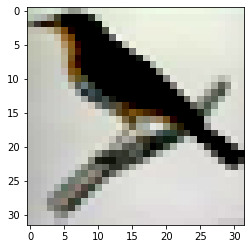

In [48]:
print("Original Image")
plt.imshow(data[0][0].permute(1, 2, 0))

Original Image


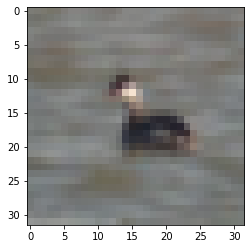

Reconstructed Image


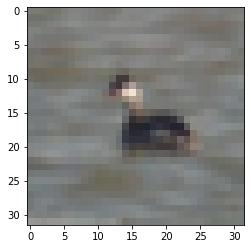

Original Image


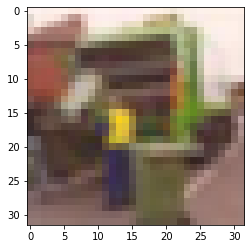

Reconstructed Image


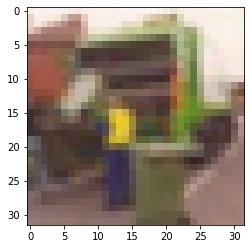

Original Image


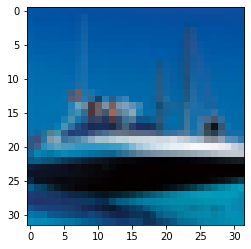

Reconstructed Image


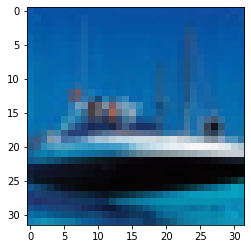

Original Image


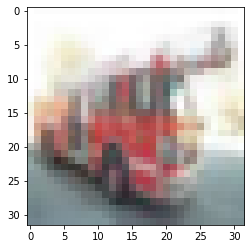

Reconstructed Image


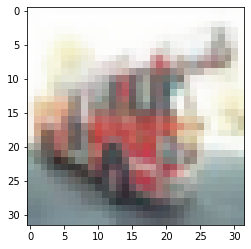

Original Image


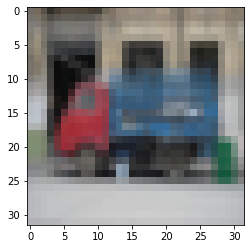

Reconstructed Image


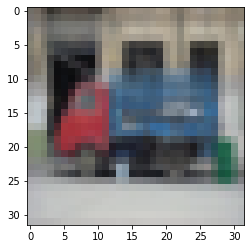

Original Image


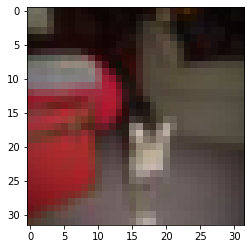

Reconstructed Image


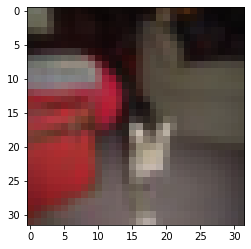

Original Image


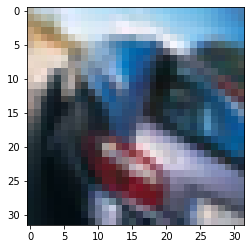

Reconstructed Image


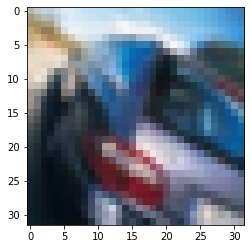

Original Image


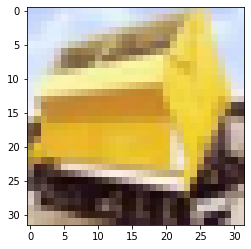

Reconstructed Image


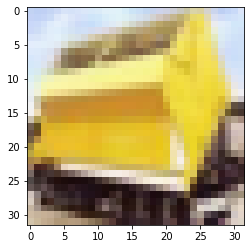

Original Image


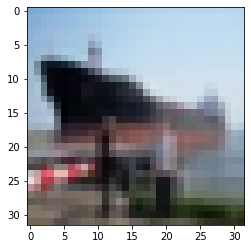

Reconstructed Image


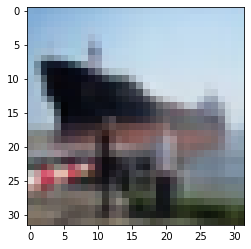

Original Image


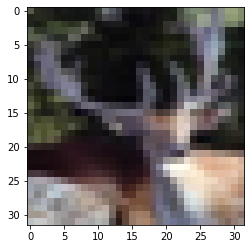

Reconstructed Image


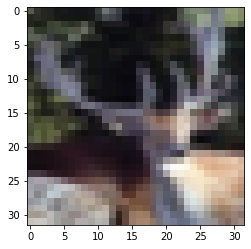

In [93]:
subset_indices = random.sample(range(0, len(trainloader)), 10)
subset = torch.utils.data.Subset(trainset, subset_indices)
trainloader_subset = torch.utils.data.DataLoader(subset, batch_size=1, num_workers=0, shuffle=False)

for i, data in enumerate(trainloader_subset):
    print("Original Image")
    original_data = data[0][0].permute(1, 2, 0)
    original_data = (original_data * 0.5) + 0.5
#     original_data = reverse_transfrom(original_data)
    plt.imshow(original_data)
    plt.show()
    print("Reconstructed Image")
    reconstructed_image = model(data[0].to(device))[0].detach().cpu()
    reconstructed_image = reconstructed_image.permute(1, 2, 0)
    reconstructed_image = (reconstructed_image * 0.5) + 0.5
    plt.imshow(reconstructed_image)
    plt.show()

In [100]:
model.encoder(data[0].to(device)).shape

torch.Size([1, 128, 30, 30])

In [67]:
to_pil = torchvision.transforms.ToPILImage()
img = to_pil(data[0][0])

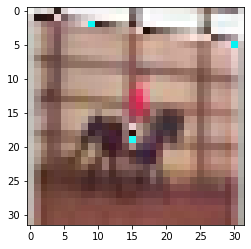

In [72]:
from IPython.display import Image 

plt.imshow(np.asarray(img))

In [89]:
for i, train_data in enumerate(raw_trainloader):
    plt.imshow(train_data[0][0])
    break

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 83, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 83, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 85, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [85]:
np.asarray(train_data[0][0].permute(1, 2, 0))

array([[[0.7137255 , 0.7647059 , 0.8352941 ],
        [0.69803923, 0.7490196 , 0.81960785],
        [0.69803923, 0.7490196 , 0.81960785],
        ...,
        [0.81960785, 0.84313726, 0.8901961 ],
        [0.8117647 , 0.8392157 , 0.8862745 ],
        [0.80784315, 0.8352941 , 0.88235295]],

       [[0.7137255 , 0.76862746, 0.827451  ],
        [0.7019608 , 0.75686276, 0.81960785],
        [0.69803923, 0.7529412 , 0.8117647 ],
        ...,
        [0.79607844, 0.8235294 , 0.87058824],
        [0.7882353 , 0.8235294 , 0.8745098 ],
        [0.78431374, 0.81960785, 0.8666667 ]],

       [[0.75686276, 0.7921569 , 0.85490197],
        [0.7490196 , 0.7882353 , 0.84705883],
        [0.74509805, 0.78431374, 0.84313726],
        ...,
        [0.78431374, 0.8235294 , 0.8666667 ],
        [0.78039217, 0.81960785, 0.8745098 ],
        [0.77254903, 0.8156863 , 0.87058824]],

       ...,

       [[0.40392157, 0.5882353 , 0.60784316],
        [0.42745098, 0.59607846, 0.61960787],
        [0.4627451 , 0

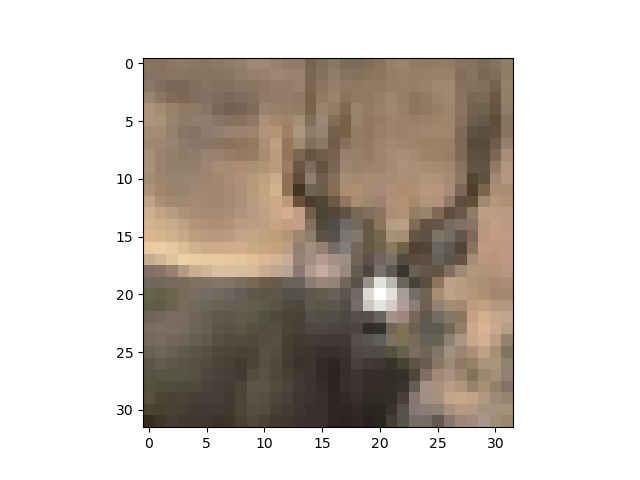

In [97]:
Image('0.1_0.1_test_images/0_13_original.png')

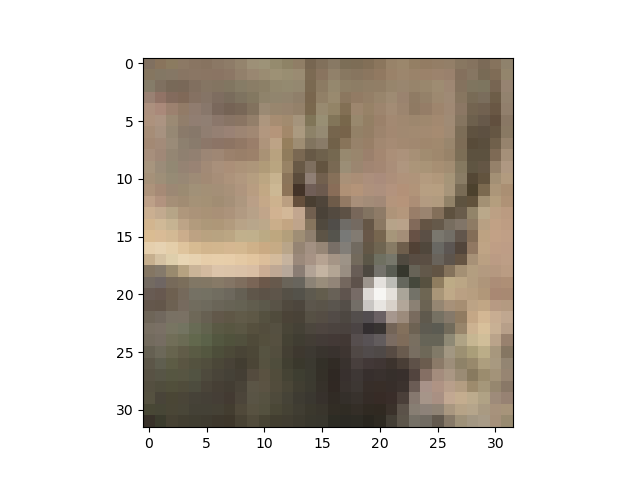

In [98]:
Image('0.1_0.1_test_images/0_13_reconstructed.png')

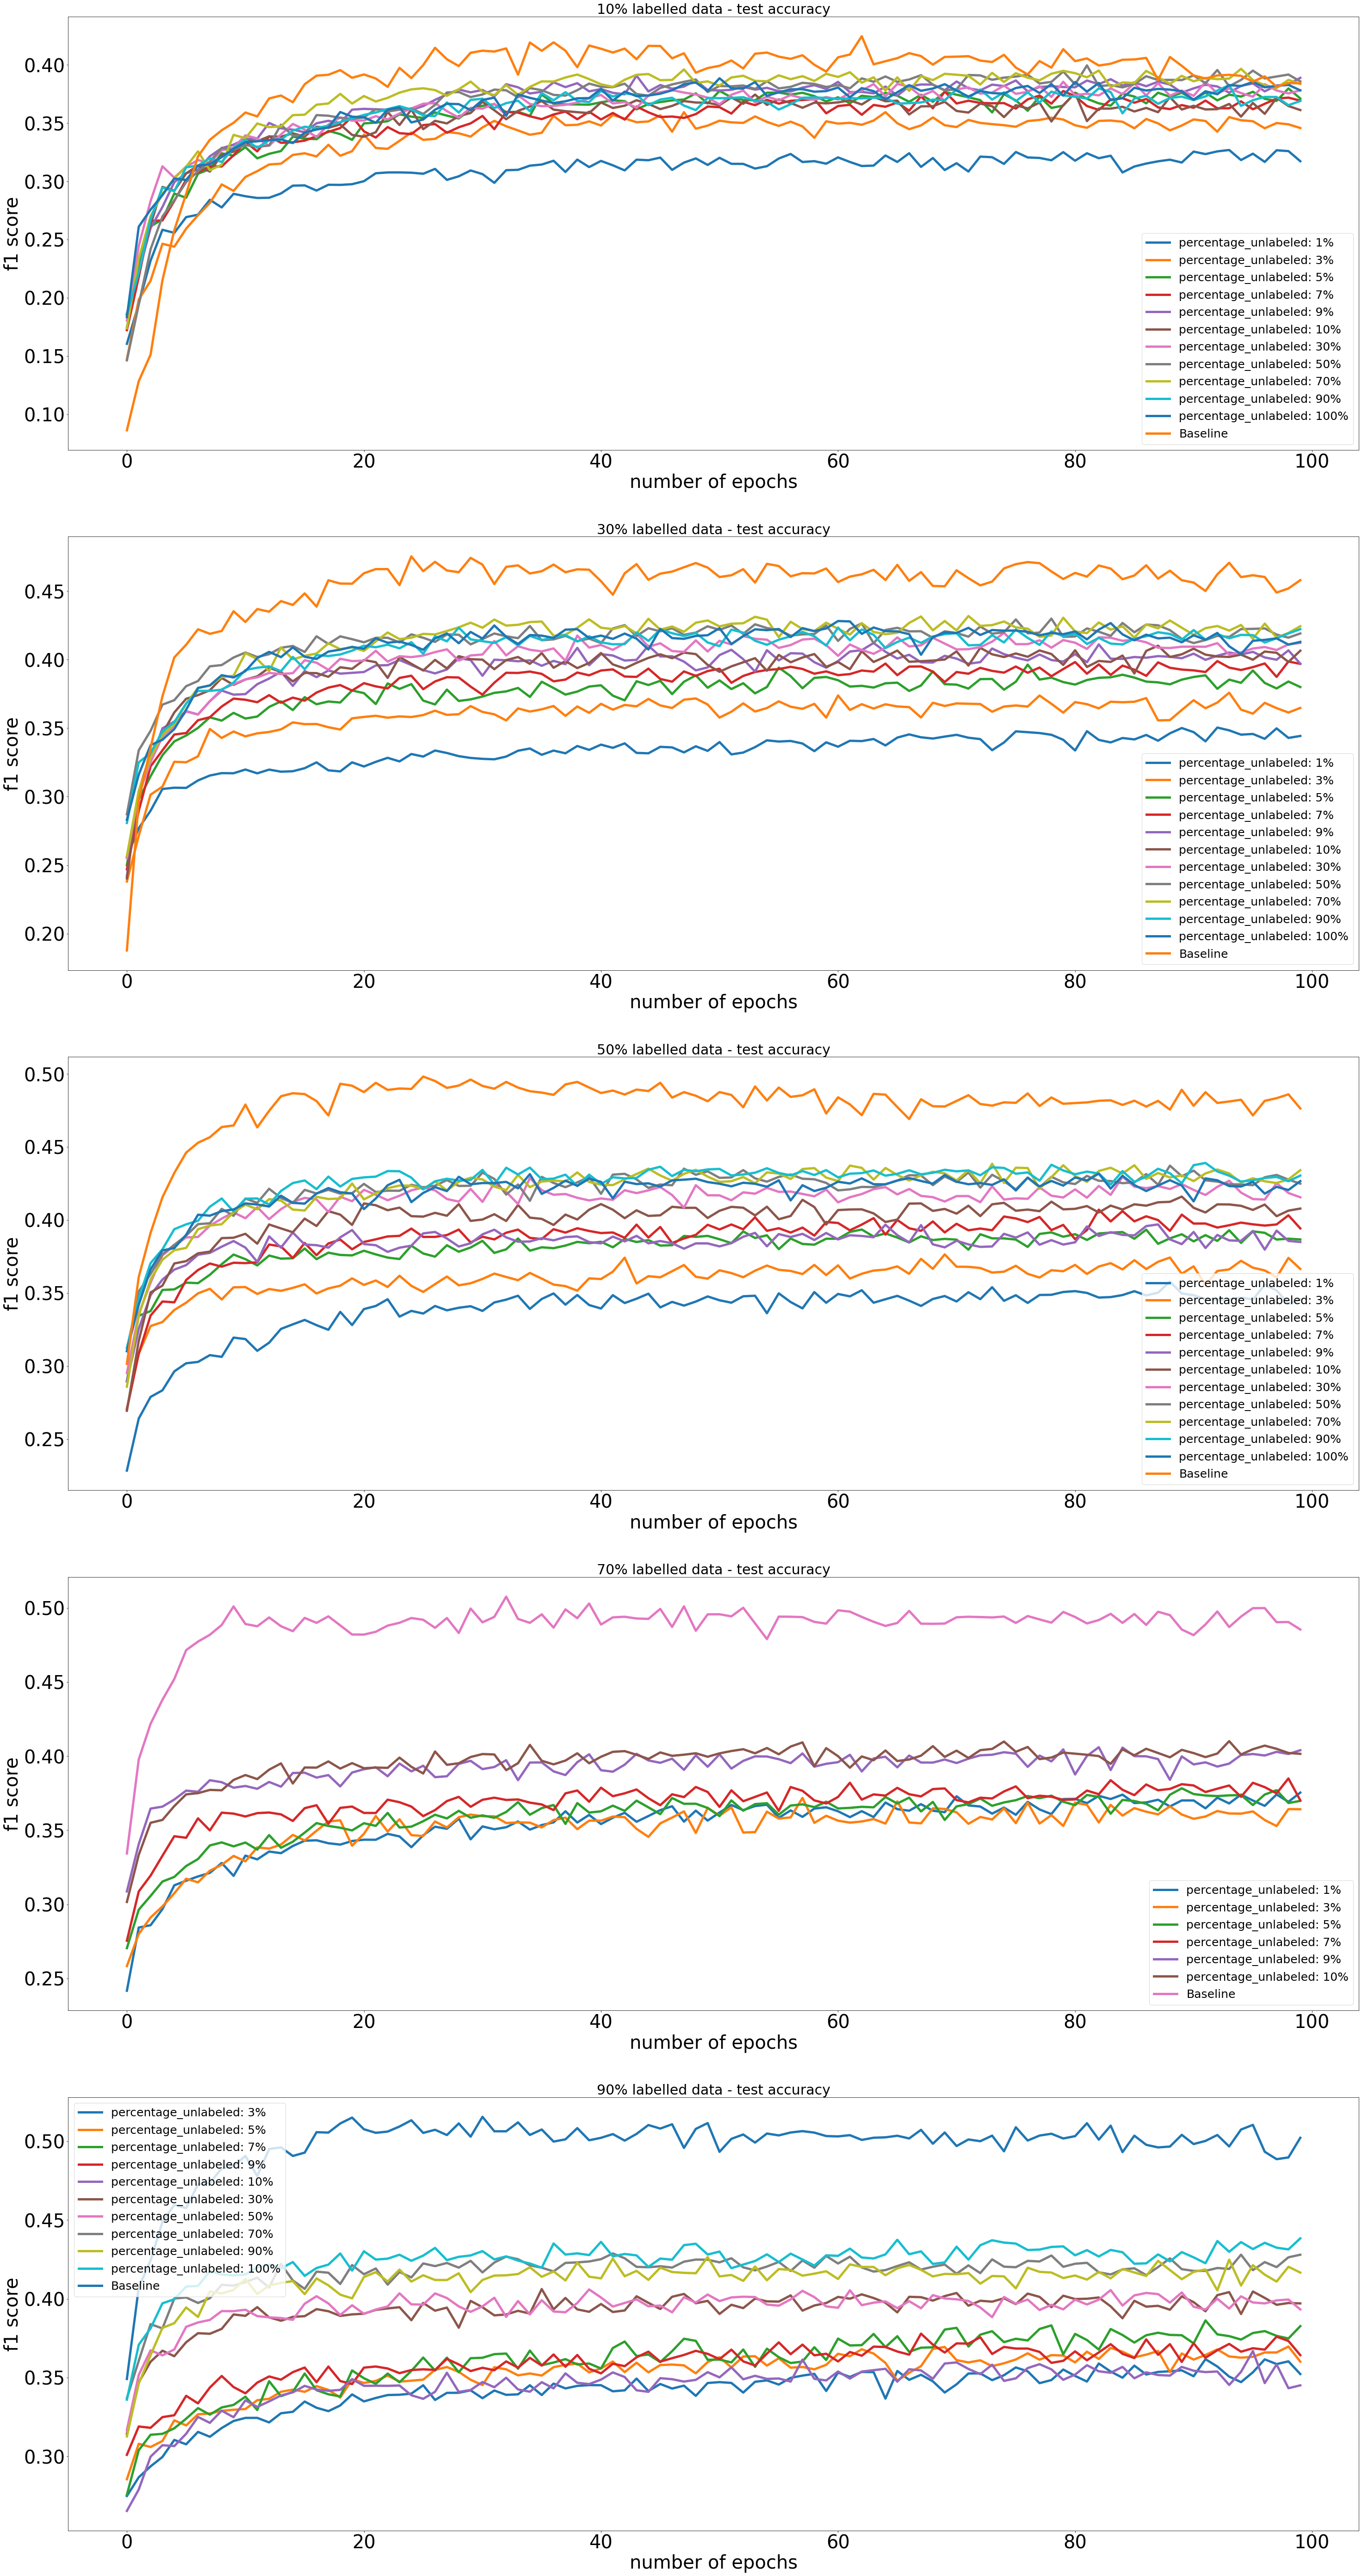

In [14]:
fig, ax = plt.subplots(5, figsize=(50, 100))
plot = True
for graph_idx, per_lab in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    for per_unlab in [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
        directory = '{}_{}_runs/finetuner'.format(per_lab, per_unlab)
        if not os.path.exists("{}/epoch_99_test_accuracy.json".format(directory)):
            continue
        data = json.load(open('{}/epoch_99_test_accuracy.json'.format(directory)))
        ax[graph_idx].plot([i for i in range(len(data))], data, 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)), linewidth=5)
    directory = '{}_{}_runs/baseline'.format(per_lab, 0.0)
    if not os.path.exists("{}/epoch_99_test_accuracy.json".format(directory)):
        plot = False
    if plot:
        data = json.load(open('{}/epoch_99_test_accuracy.json'.format(directory)))
        ax[graph_idx].plot([i for i in range(len(data))], data, label='Baseline', linewidth=5)
    
    ax[graph_idx].legend(prop={'size': 25})
#     ax[graph_idx].set_ylim(0.4, 0.55)
    ax[graph_idx].tick_params(axis='both', which='major', labelsize=40)
    ax[graph_idx].set_xlabel('number of epochs', fontsize=40)
    ax[graph_idx].set_ylabel('f1 score', fontsize=40)
    ax[graph_idx].set_title("{}% labelled data - test accuracy".format(int(per_lab * 100)), fontsize=30)
plt.show()

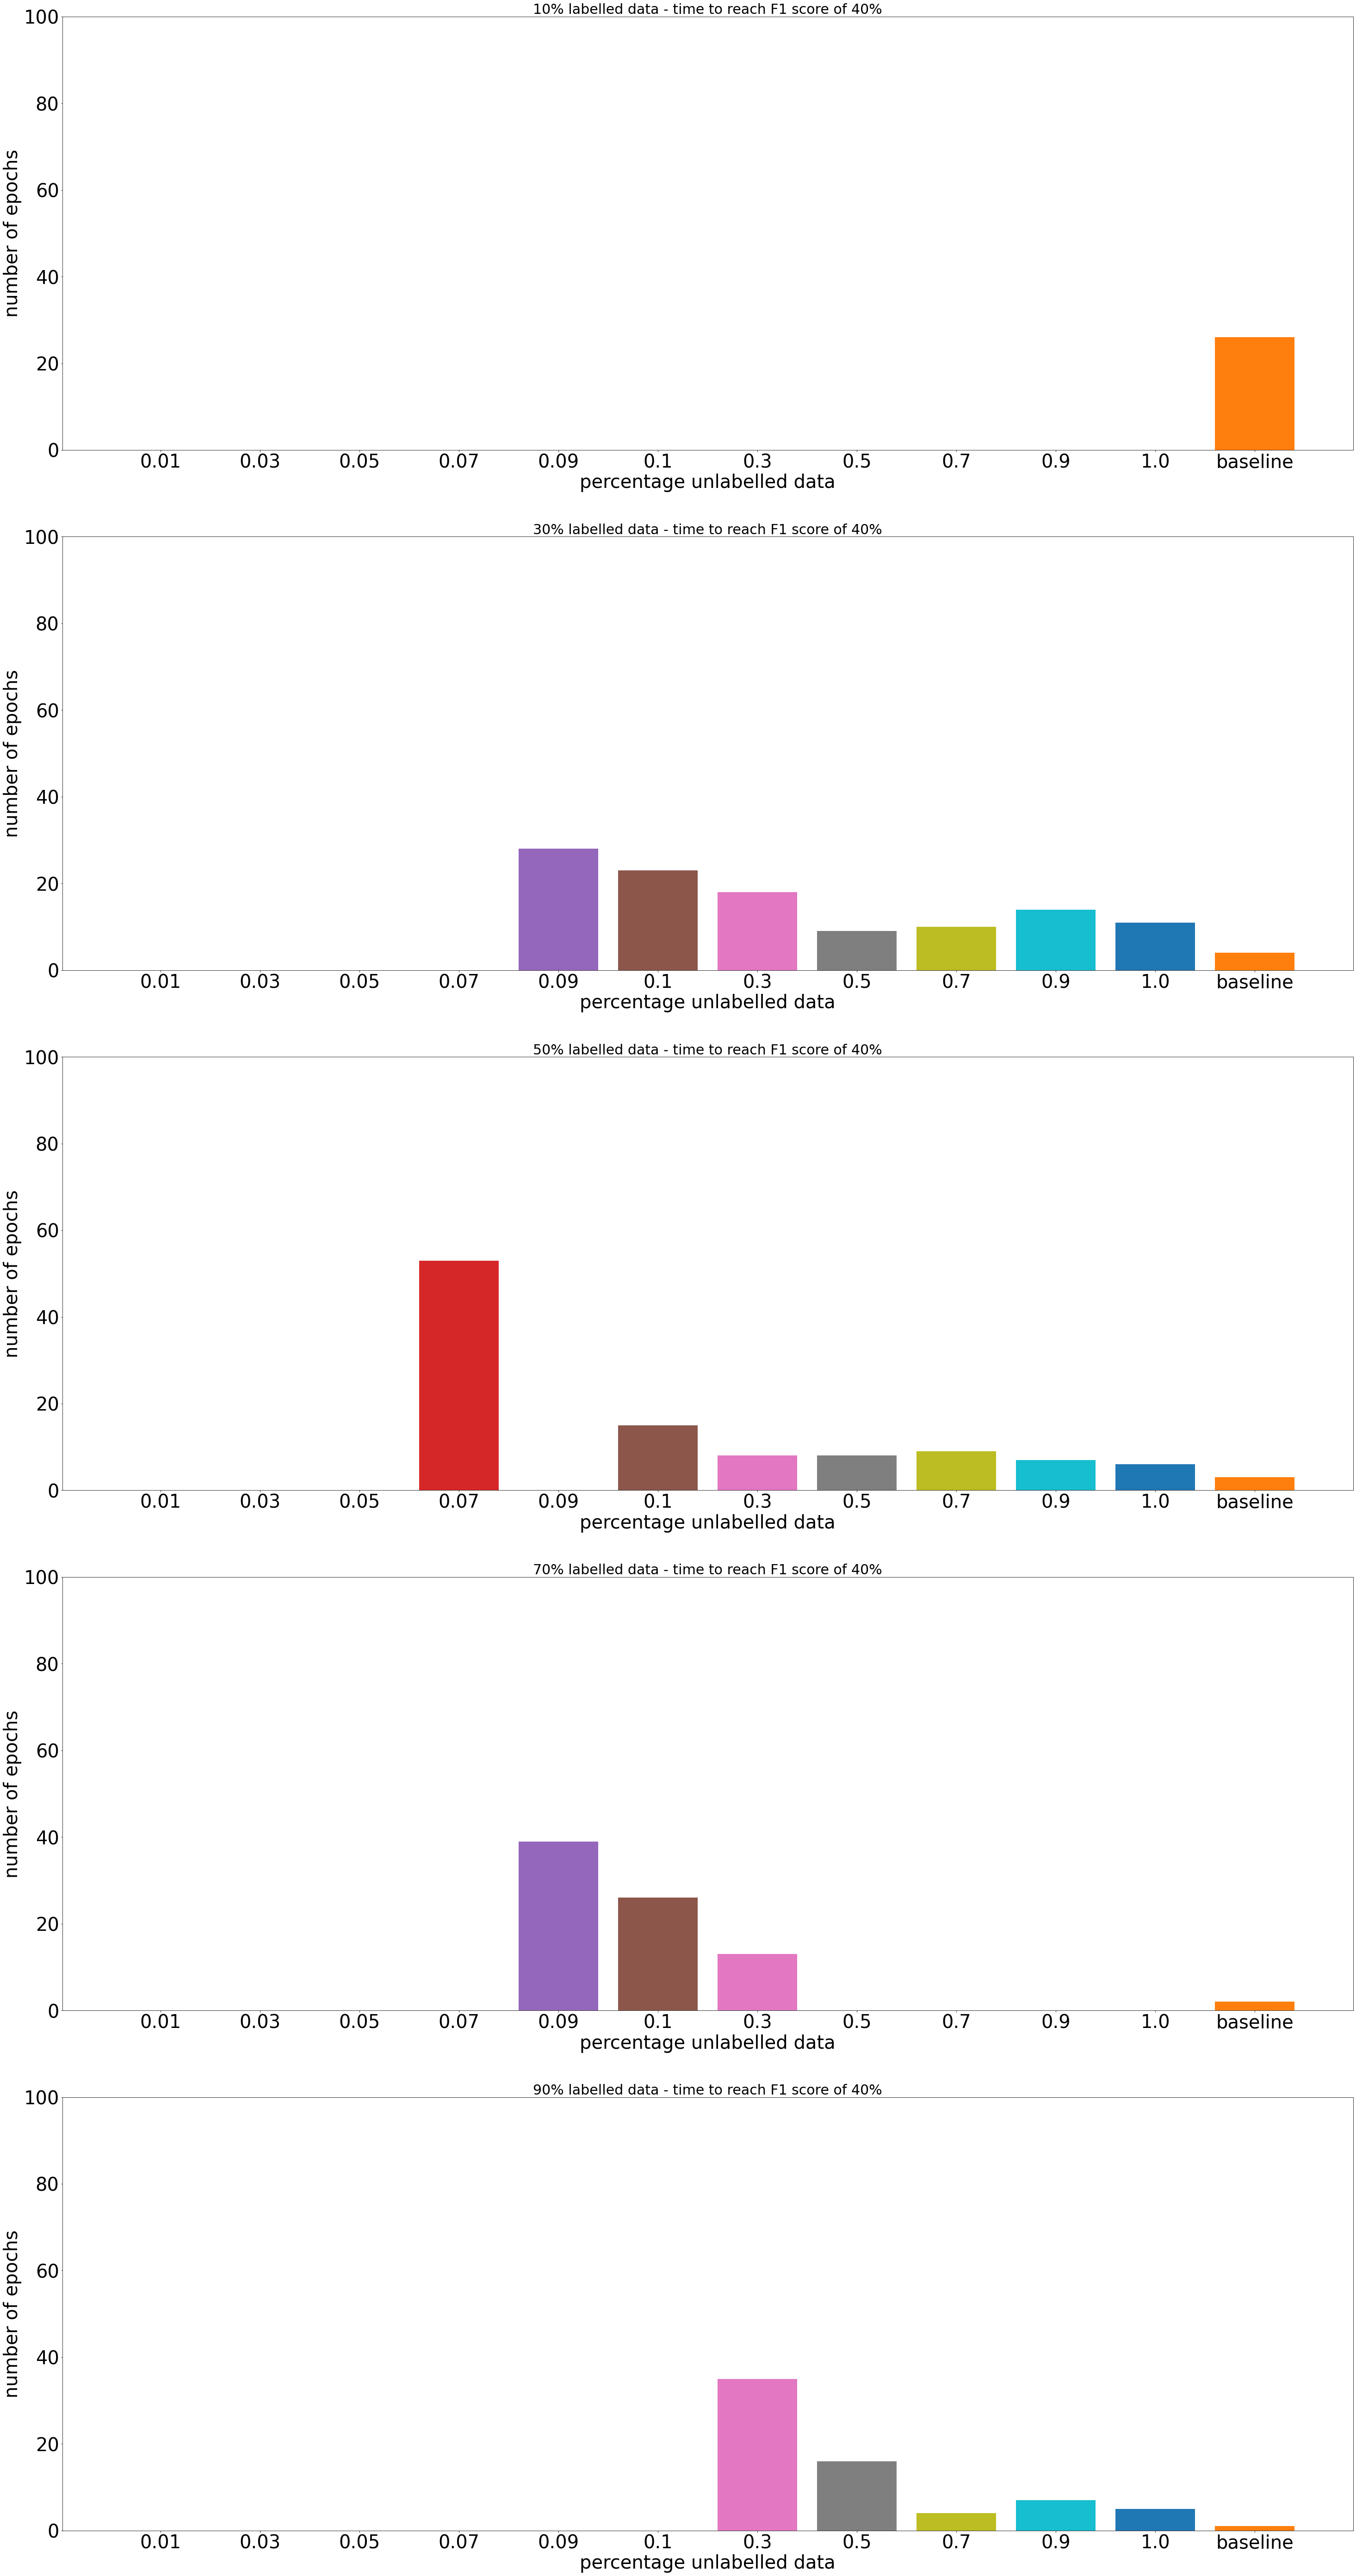

In [13]:
fig, ax = plt.subplots(5, figsize=(50, 100))
plot = True
for graph_idx, per_lab in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    for x_idx, per_unlab in enumerate([0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]):
        directory = '{}_{}_runs/finetuner'.format(per_lab, per_unlab)
        if not os.path.exists("{}/time_to_accuracy.json".format(directory)):
            ax[graph_idx].bar([x_idx], [0], 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)))
            continue
        data = json.load(open('{}/time_to_accuracy.json'.format(directory)))
        ax[graph_idx].bar([x_idx], [data[1]], 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)))
    directory = '{}_{}_runs/baseline'.format(per_lab, 0.0)
    if not os.path.exists("{}/time_to_accuracy.json".format(directory)):
        plot = False
    if plot:
        data = json.load(open('{}/time_to_accuracy.json'.format(directory)))
        ax[graph_idx].bar([x_idx + 1], [data[1]], label='Baseline')
    
#     ax[graph_idx].legend(prop={'size': 25})
    ax[graph_idx].set_ylim(0, 100)
    ax[graph_idx].tick_params(axis='both', which='major', labelsize=40)
    ax[graph_idx].set_xticks(range(x_idx + 2))
    ax[graph_idx].set_xticklabels([0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 'baseline'])
    ax[graph_idx].set_xlabel('percentage unlabelled data', fontsize=40)
    ax[graph_idx].set_ylabel('number of epochs', fontsize=40)
    ax[graph_idx].set_title("{}% labelled data - time to reach F1 score of 40%".format(int(per_lab * 100)), fontsize=30)
plt.show()

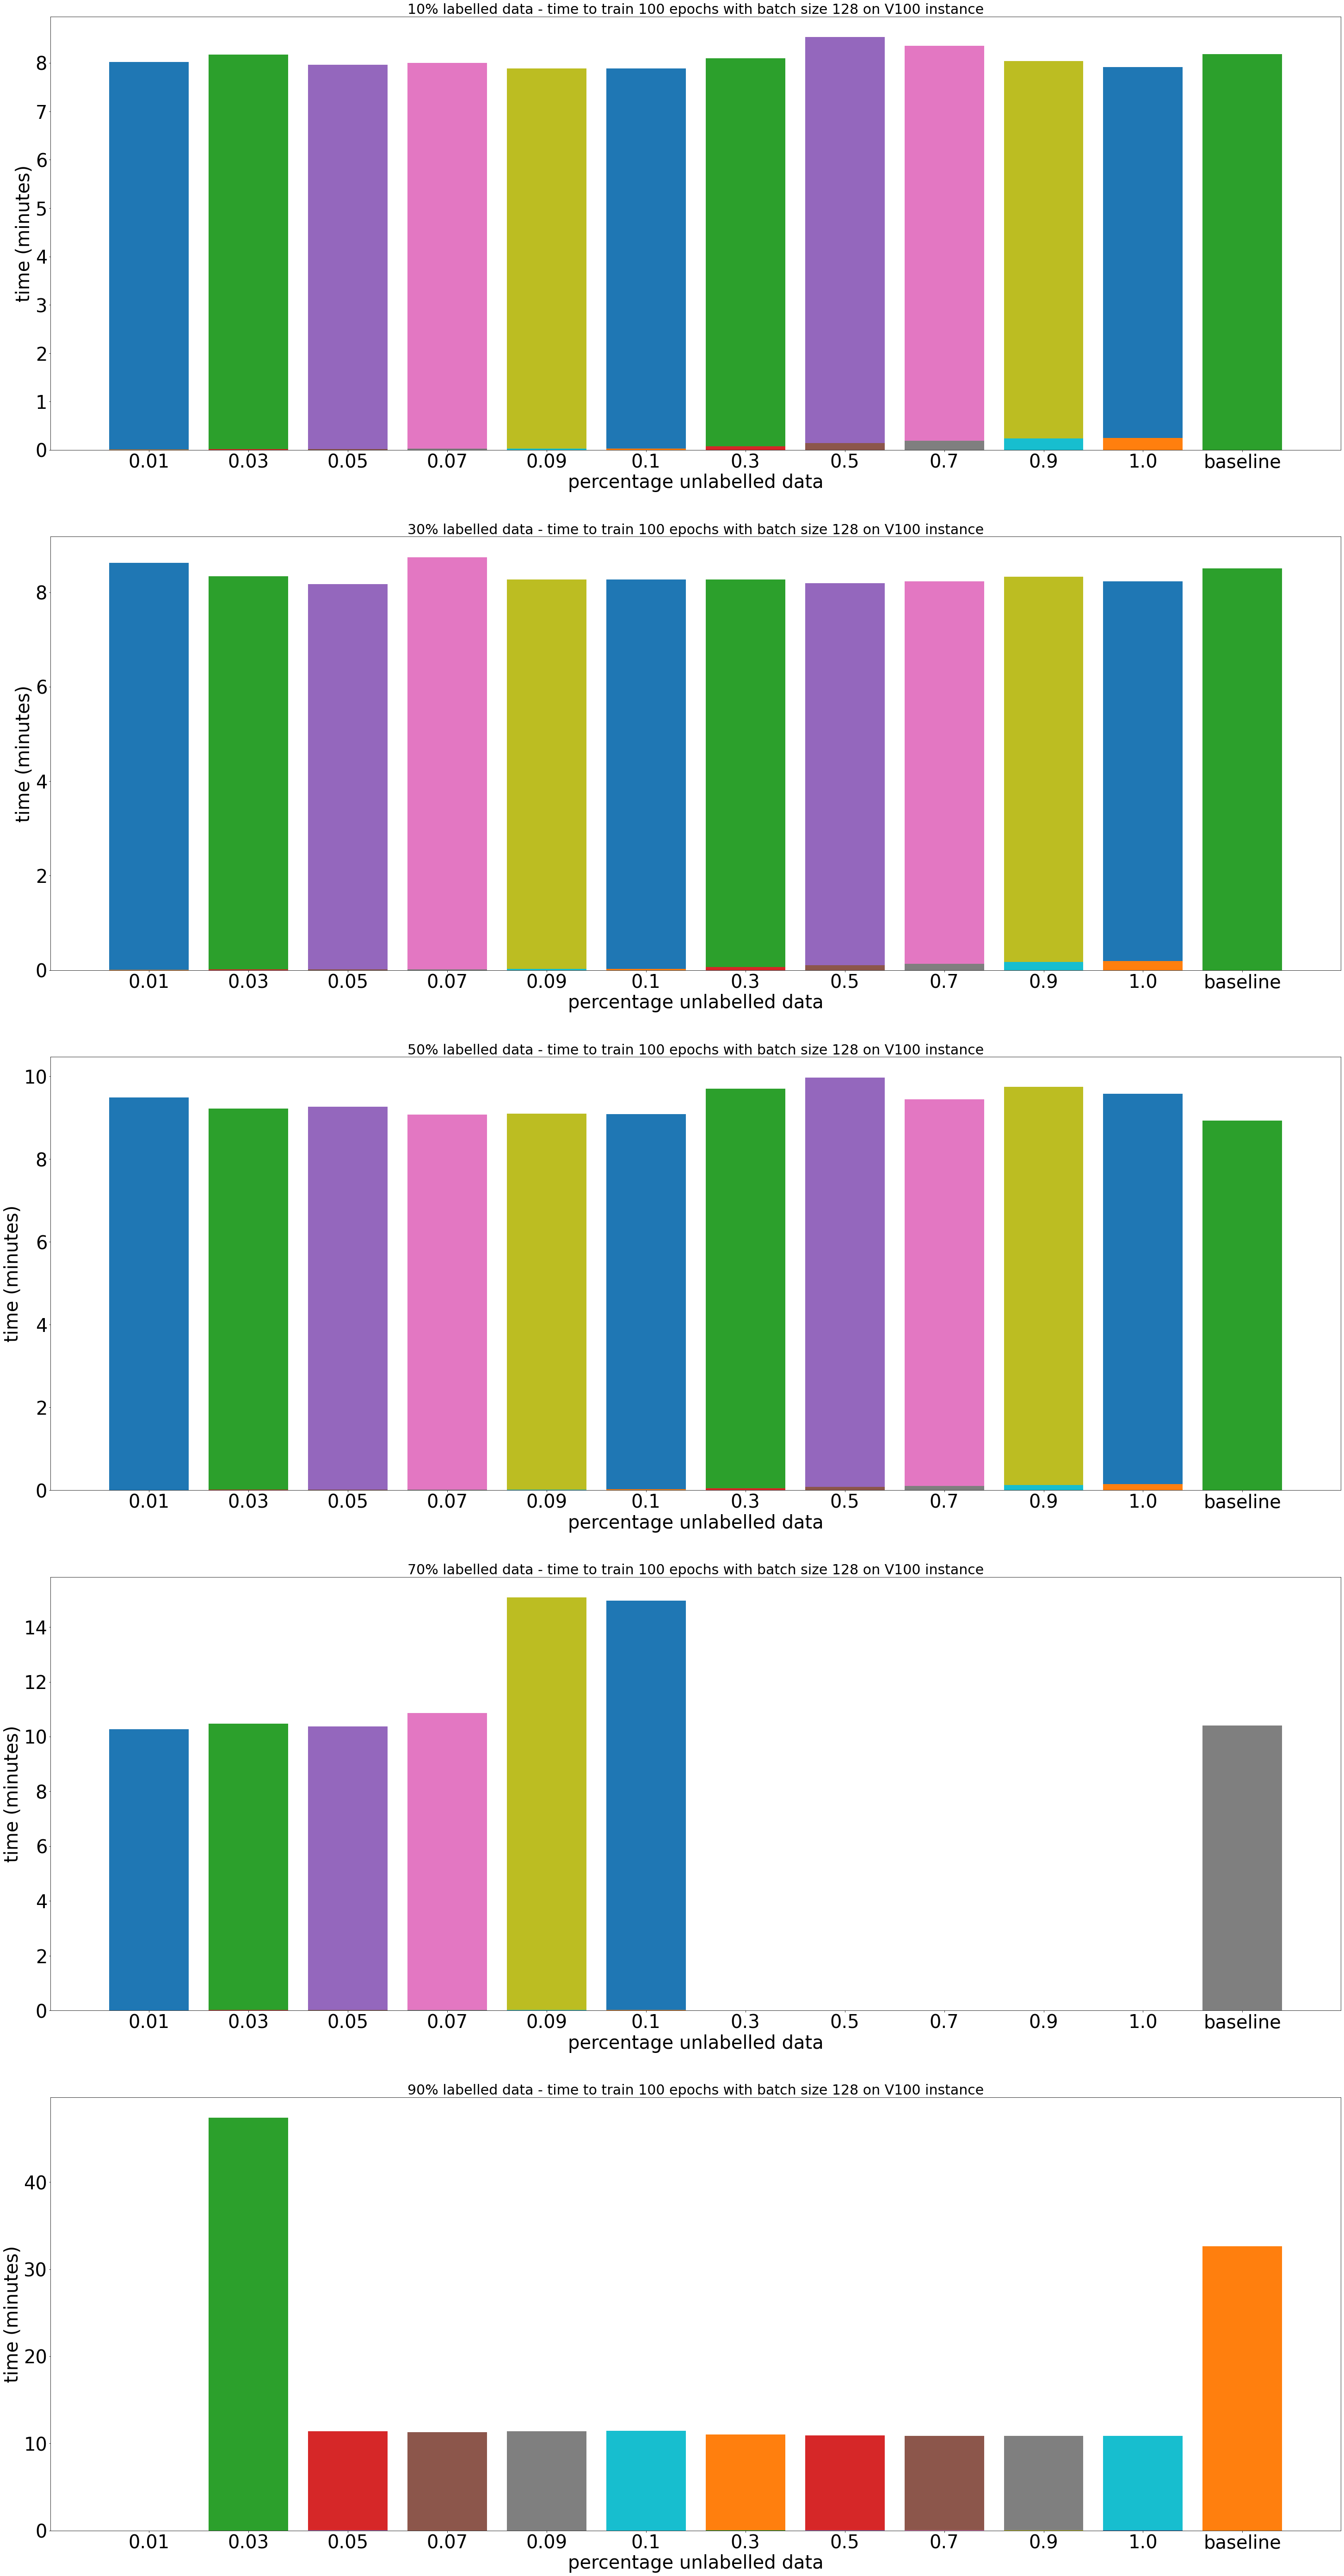

In [16]:
fig, ax = plt.subplots(5, figsize=(50, 100))
plot = True
for graph_idx, per_lab in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    for x_idx, per_unlab in enumerate([0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]):
        directory = '{}_{}_runs/finetuner'.format(per_lab, per_unlab)
        if not os.path.exists("{}/time_taken.json".format(directory)):
            ax[graph_idx].bar([x_idx], [0], 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)))
            continue
        data = json.load(open('{}/time_taken.json'.format(directory)))
        ax[graph_idx].bar([x_idx], [data[0] * 1. / 60], 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)))
        
        directory = '{}_{}_runs/pretrainer'.format(per_lab, per_unlab)
        if not os.path.exists("{}/time_taken.json".format(directory)):
            ax[graph_idx].bar([x_idx], [0], 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)))
            continue
        data = json.load(open('{}/time_taken.json'.format(directory)))
        ax[graph_idx].bar([x_idx], [data[0] * 1. / 60], 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)))
    directory = '{}_{}_runs/baseline'.format(per_lab, 0.0)
    if not os.path.exists("{}/time_taken.json".format(directory)):
        plot = False
    if plot:
        data = json.load(open('{}/time_taken.json'.format(directory)))
        ax[graph_idx].bar([x_idx + 1], [data[0] * 1. / 60], label='Baseline')
    
#     ax[graph_idx].legend(prop={'size': 25})
    ax[graph_idx].tick_params(axis='both', which='major', labelsize=40)
    ax[graph_idx].set_xticks(range(x_idx + 2))
    ax[graph_idx].set_xticklabels([0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 'baseline'])
    ax[graph_idx].set_xlabel('percentage unlabelled data', fontsize=40)
    ax[graph_idx].set_ylabel('time (minutes)', fontsize=40)
    ax[graph_idx].set_title("{}% labelled data - time to train 100 epochs with batch size 128 on V100 instance".format(int(per_lab * 100)), fontsize=30)
plt.show()

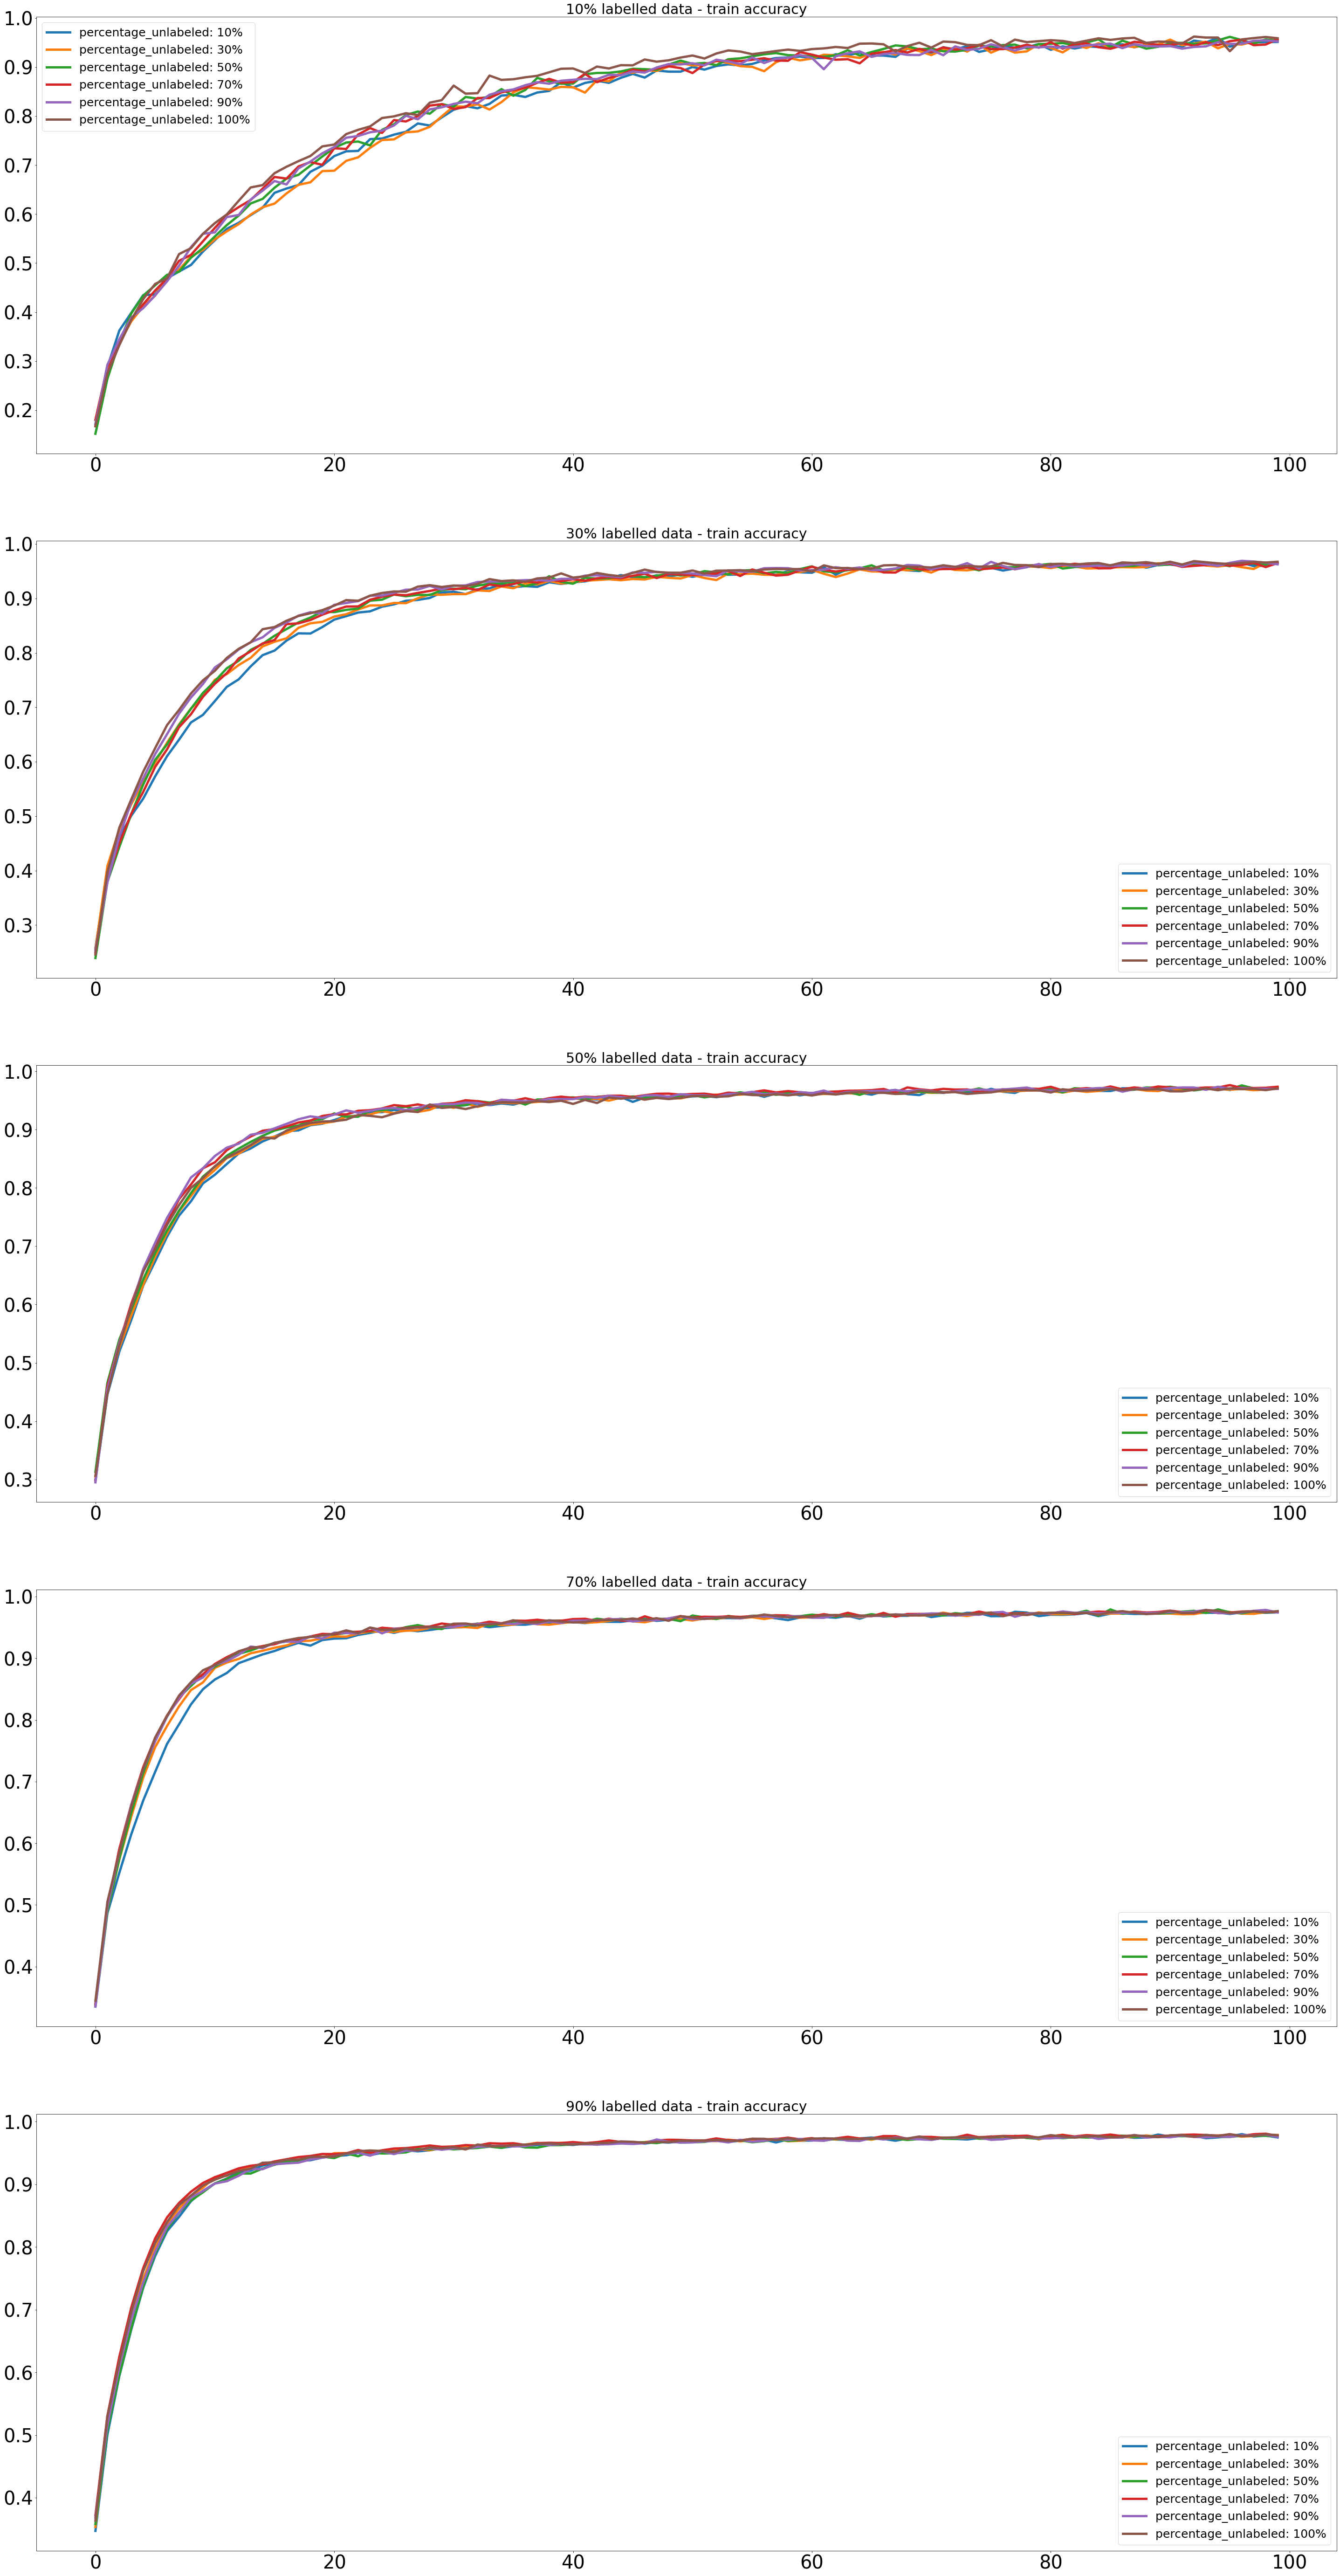

In [32]:
fig, ax = plt.subplots(5, figsize=(50, 100))
for graph_idx, per_lab in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    for per_unlab in [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
        directory = '{}_{}_runs/finetuner'.format(per_lab, per_unlab)
        data = json.load(open('{}/epoch_99_accuracy.json'.format(directory)))
        ax[graph_idx].plot([i for i in range(len(data))], data, 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)), linewidth=5)
    ax[graph_idx].legend(prop={'size': 25})
    ax[graph_idx].tick_params(axis='both', which='major', labelsize=40)
    ax[graph_idx].set_title("{}% labelled data - train accuracy".format(int(per_lab * 100)), fontsize=30)
plt.show()

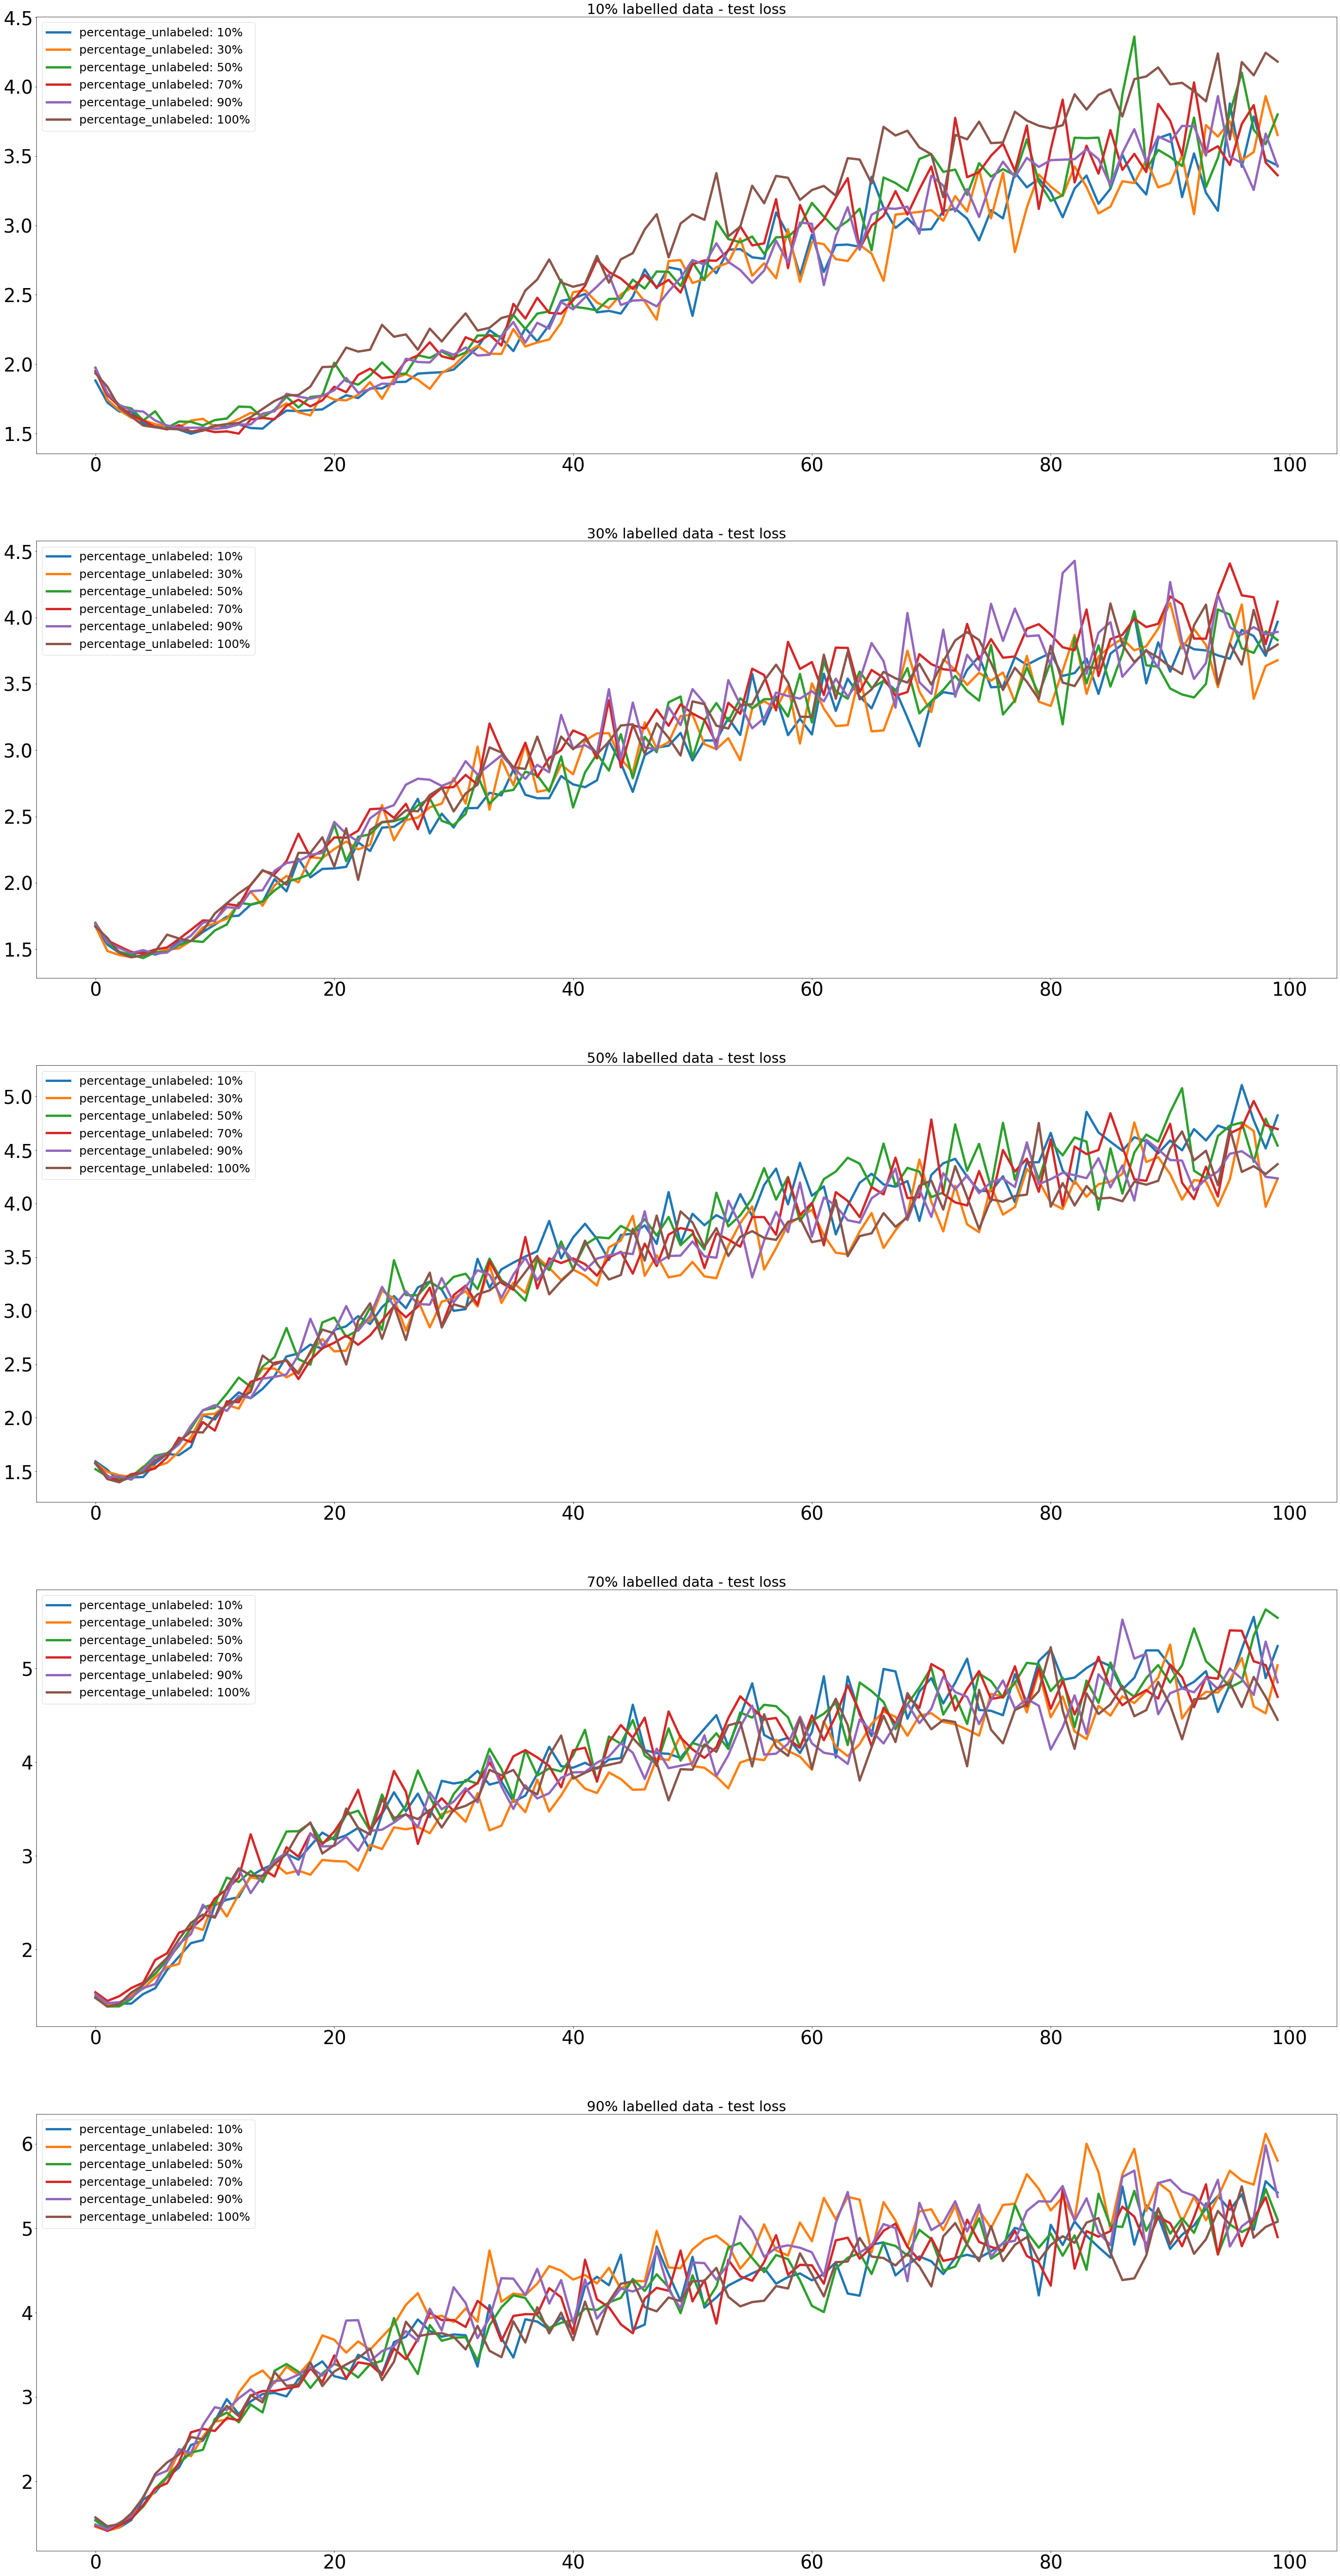

In [34]:
fig, ax = plt.subplots(5, figsize=(50, 100))
for graph_idx, per_lab in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    for per_unlab in [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
        directory = '{}_{}_runs/finetuner'.format(per_lab, per_unlab)
        data = json.load(open('{}/epoch_99_test_loss.json'.format(directory)))
        ax[graph_idx].plot([i for i in range(len(data))], data, 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)), linewidth=5)
    ax[graph_idx].legend(prop={'size': 25})
    ax[graph_idx].tick_params(axis='both', which='major', labelsize=40)
    ax[graph_idx].set_title("{}% labelled data - test loss".format(int(per_lab * 100)), fontsize=30)
plt.show()

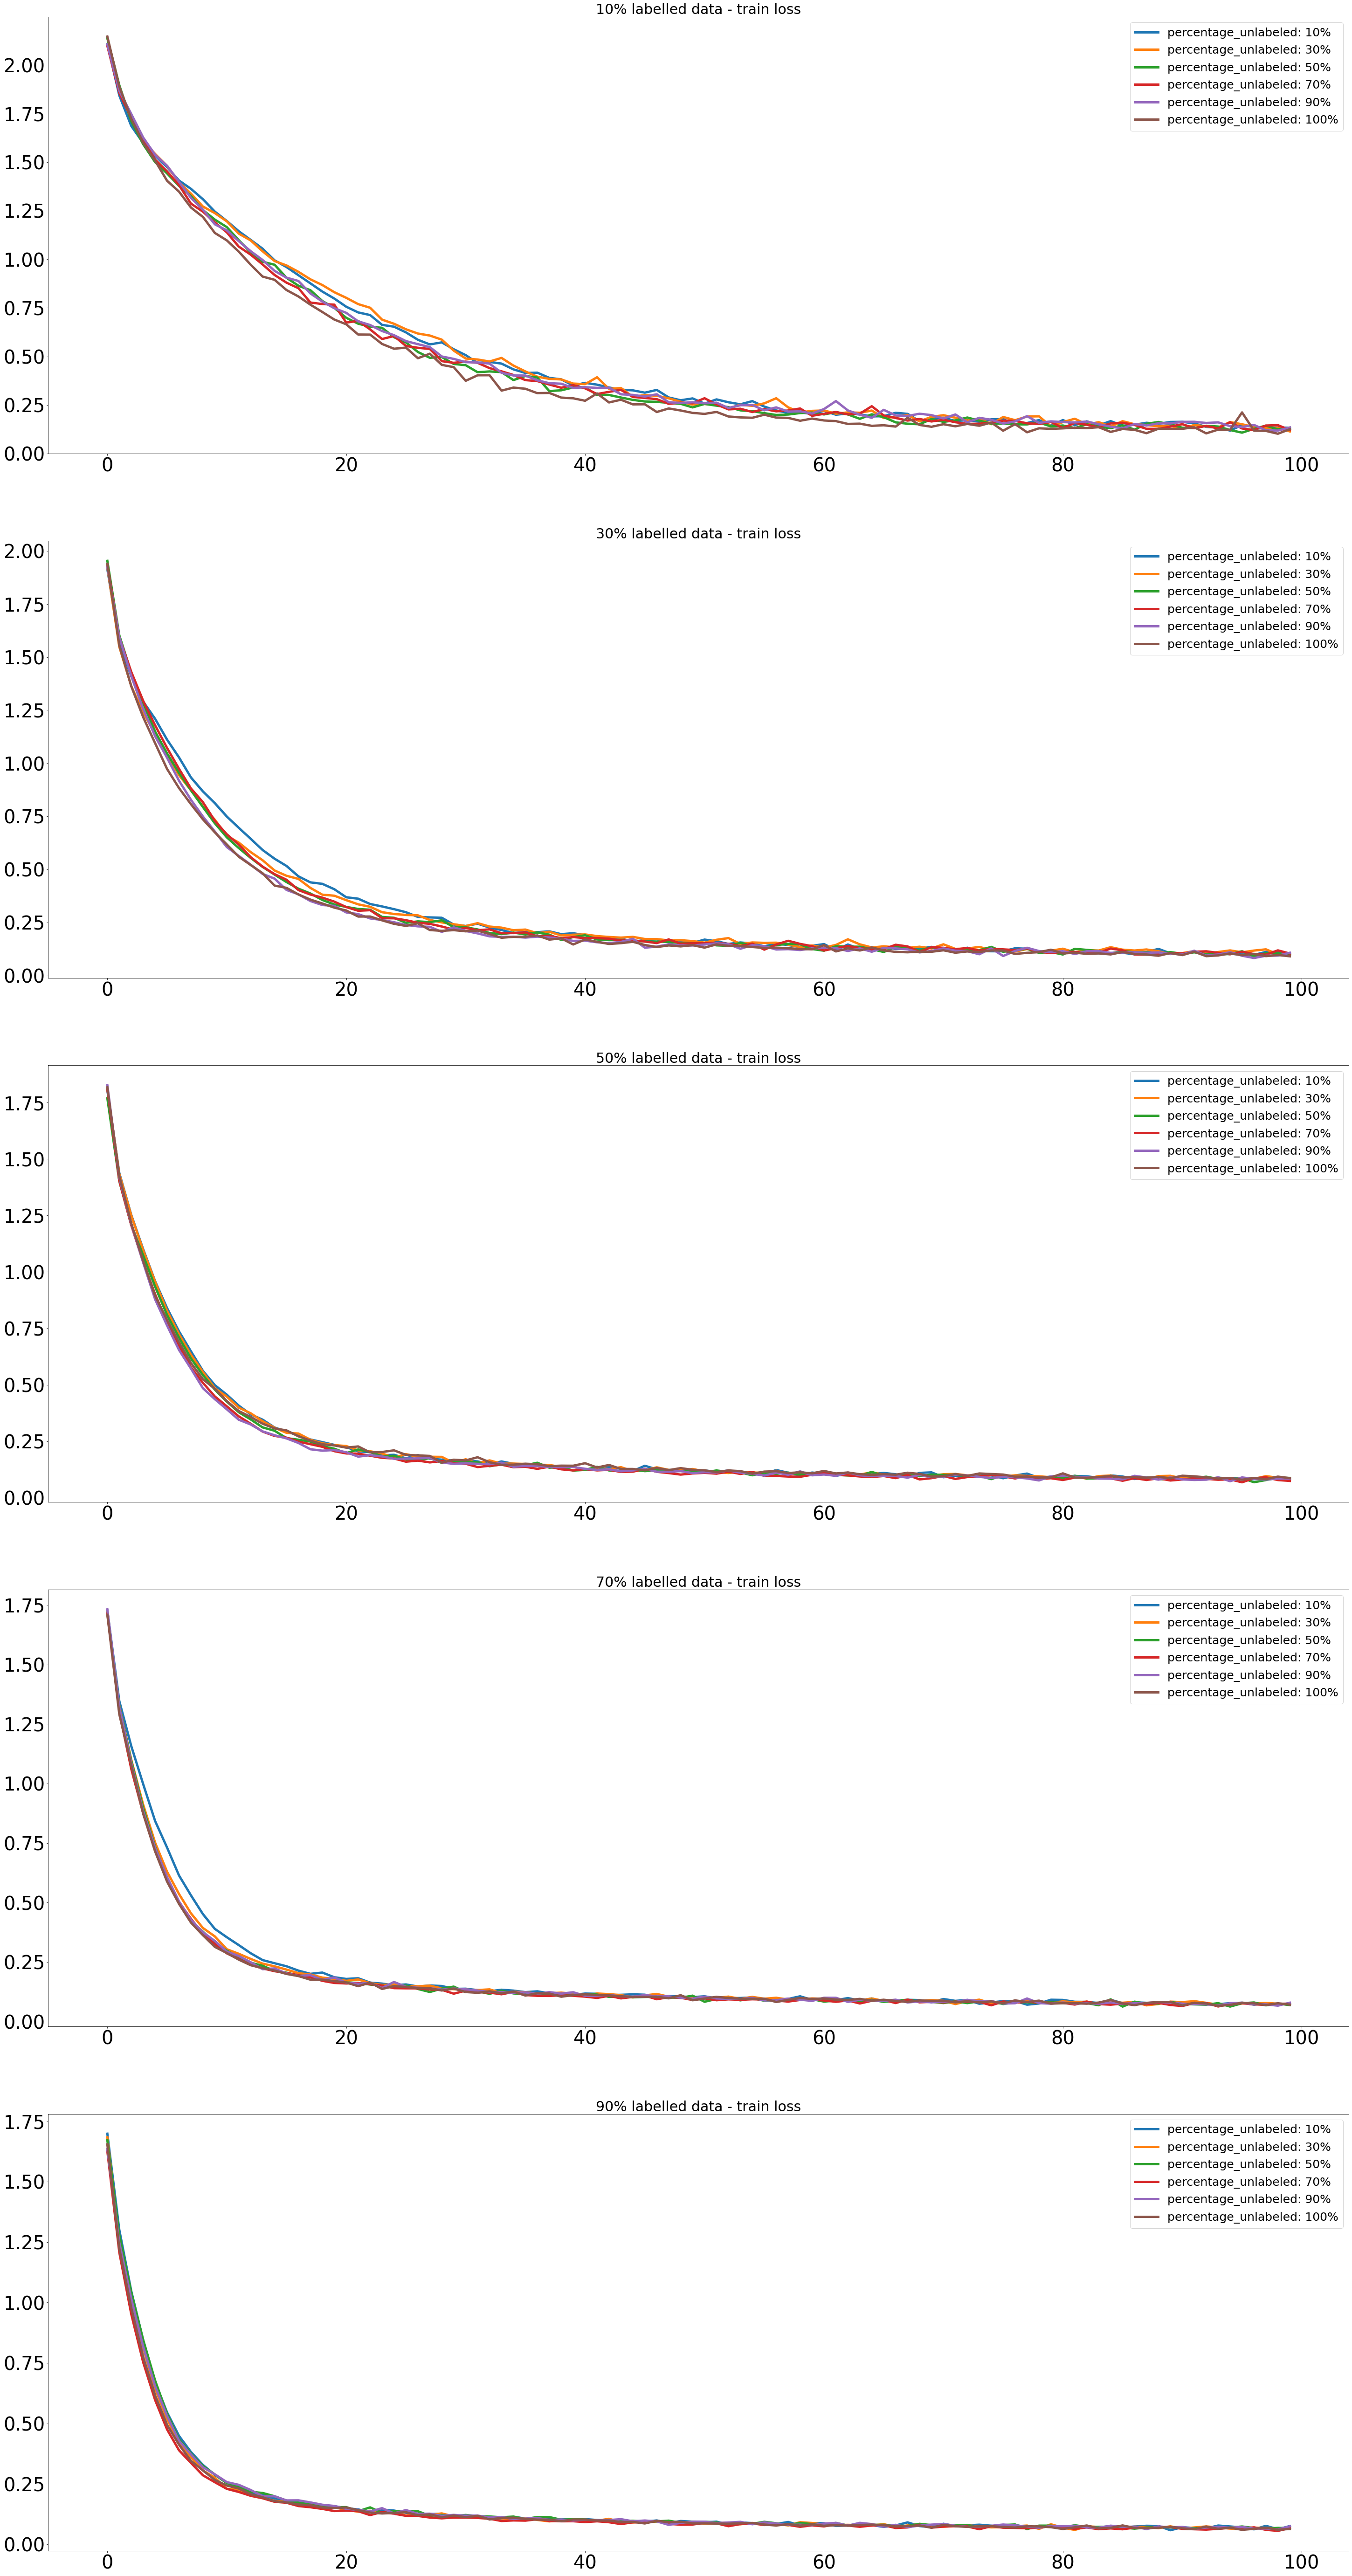

In [36]:
fig, ax = plt.subplots(5, figsize=(50, 100))
for graph_idx, per_lab in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    for per_unlab in [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
        directory = '{}_{}_runs/finetuner'.format(per_lab, per_unlab)
        data = json.load(open('{}/epoch_99_loss.json'.format(directory)))
        ax[graph_idx].plot([i for i in range(len(data))], data, 
                           label='percentage_unlabeled: {}%'.format(int(per_unlab * 100)), linewidth=5)
    ax[graph_idx].legend(prop={'size': 25})
    ax[graph_idx].tick_params(axis='both', which='major', labelsize=40)
    ax[graph_idx].set_title("{}% labelled data - train loss".format(int(per_lab * 100)), fontsize=30)
plt.show()